In [85]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import os
import PIL
import torchvision.transforms as transforms
import tqdm
import scipy.ndimage as sim

import models
import utils

from mltools.networks import networks
from mltools.utils import cuda_tools
from mltools import ml_utils

device=cuda_tools.get_freer_device()

import importlib
importlib.reload(models)
importlib.reload(utils)
importlib.reload(ml_utils)

memory_available [78449]
best GPU: 0


<module 'mltools.ml_utils' from '/n/home12/cfpark00/MLtools/mltools/ml_utils.py'>

In [91]:
run_choice=1

In [92]:
def get_step(path):
    return int(path.split("_")[-1].split(".")[0])

In [94]:
if run_choice==0:
    ckpt_paths=glob.glob("./data/celeba/run1/ckpts/ckpt_*.pth")
    ckpt_paths.sort(key=get_step)
    classifier_ckpt="./data/celeba/run1_classifier/ckpts/ckpt_100000.pth"
elif run_choice==1:
    ckpt_paths=glob.glob("./data/celeba/run2/ckpts/ckpt_*.pth")
    ckpt_add_paths=glob.glob("./data/celeba/run2_re/ckpts/ckpt_*.pth")
    ckpt_paths.sort(key=get_step)
    ckpt_add_paths.sort(key=get_step)
    ckpt_paths=ckpt_paths+ckpt_add_paths
    classifier_ckpt="./data/celeba/run2_classifier/ckpts/ckpt_10000.pth"
elif run_choice==2:
    ckpt_paths=glob.glob("./data/celeba/ms_bench_0/ckpts/ckpt_*.pth")
    ckpt_paths.sort(key=get_step)
    classifier_ckpt="./data/celeba/run2_classifier/ckpts/ckpt_10000.pth"
else:
    raise ValueError("Invalid run choice")
len(ckpt_paths)

43

In [95]:
beta_settings={"gamma_max":10.0, "gamma_min":-5.0, "noise_schedule":"learned_linear", "type":"logsnr"}
net=networks.CUNet(shape=(3,64,64),chs=[64,128,256],mid_attn=True,num_res_blocks=2,norm_groups=4,v_conditioning_dims=[4],t_conditioning=True)
vdm=models.GenVDiff(net=net,beta_settings=beta_settings,data_noise=1e-3)
vdm.optimizer=torch.optim.Adam(vdm.parameters(),lr=1e-4)
vdm=vdm.to(device)
vdm=vdm.eval()

In [96]:
net=networks.CUNet(shape=(3,64,64),chs=[64,64,128],out_channels=64,mid_attn=True,num_res_blocks=2,norm_groups=4,)
classifier=models.Classifier(net=net,n_classes=[2,2])
classifier.load_state_dict(torch.load(classifier_ckpt))
classifier=classifier.to(device)
classifier=classifier.eval()

In [97]:
probss=[]
gens=[]
for l in [[0,0],[0,1],[1,0],[1,1]]:
    probss_=[]
    steps=[]
    for ckpt_path in tqdm.tqdm(ckpt_paths):
        step=get_step(ckpt_path)
        steps.append(step)
        vdm.load_state_dict(torch.load(ckpt_path))

        suprep=4
        rep=16
        probs=[]
        c=torch.nn.functional.one_hot(torch.tensor(l),num_classes=2).reshape(1,-1).float().repeat(rep,1).to(device)
        for i in range(suprep):
            with torch.no_grad():
                generations=vdm.generate(c=c)
                if i==0:
                    gens.append(generations.detach().cpu().numpy())
                probs_=classifier.classify(generations,return_probs=True)
                probs.append(torch.stack(probs_,dim=-1).detach().cpu().numpy())
        probs=np.concatenate(probs,axis=0)
        probss_.append(probs)
    probss.append(np.stack(probss_,axis=0))
probss=np.stack(probss,axis=0)
gens=np.concatenate(gens,axis=0).reshape(4,len(ckpt_paths),*gens[0].shape)
probss.shape,gens.shape

100%|██████████| 43/43 [01:00<00:00,  1.41s/it]


((4, 43, 64, 2, 2), (4, 43, 16, 3, 64, 64))

In [98]:
if run_choice==0:
    labels=["Non Black Hair No Glasses","Non Black Hair With Glasses","Black Hair No Glasses","Black Hair With Glasses"]
    i_testing=3
    i_for_trajs=[1,1]
    ax_names=["Black Hair","Glasses"]
elif run_choice in [1,2,3,4]:
    labels=["Female Not Smiling","Female Smiling","Male Not Smiling","Male Smiling"]
    i_testing=1
    i_for_trajs=[0,1]
    ax_names=["Female","Smiling"]
else:
    raise ValueError("Invalid run choice")

In [99]:
mean_probss=probss.mean(axis=2)
traj=[]
for i,i_for_traj in enumerate(i_for_trajs):
    traj.append(mean_probss[:,:,i_for_traj,i])
traj=np.stack(traj,axis=-1)
traj.shape

(4, 43, 2)

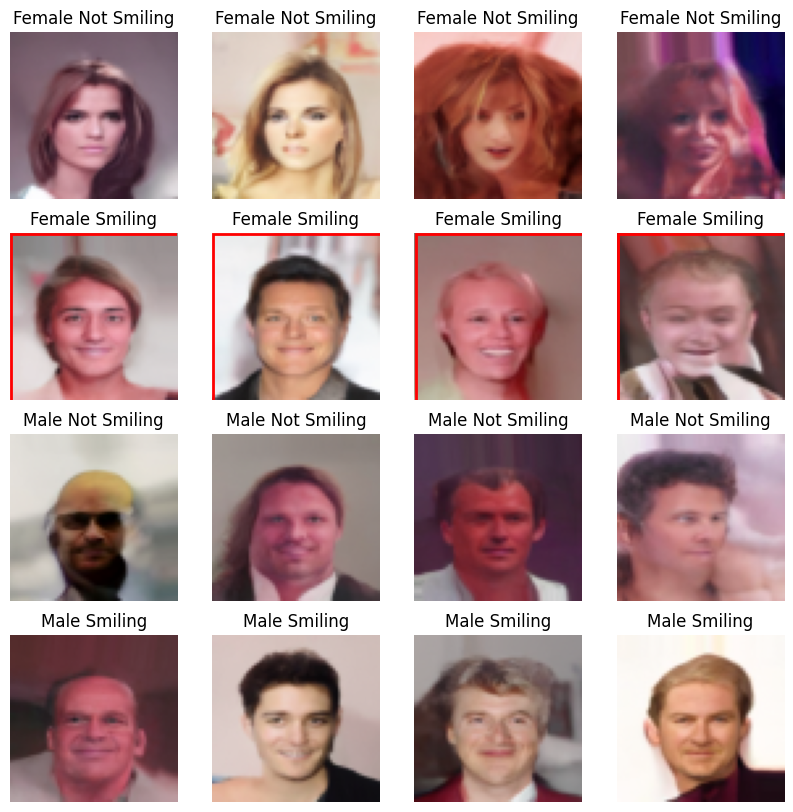

In [100]:
i_step=15

fig=plt.figure(figsize=(10,10))
for i_class in range(4):
    for i_samp in range(4):
        plt.subplot(4,4,i_class*4+i_samp+1)
        im=np.clip(gens[i_class,i_step][i_samp].transpose(1,2,0),0,1)
        plt.imshow(im)
        plt.title(str(labels[i_class]),)
        if i_class==i_testing:#make red box
            plt.gca().add_patch(plt.Rectangle((0,0),65,65,linewidth=2,edgecolor='r',facecolor='none'))
        plt.axis("off")

Text(0, 0.5, 'Smiling')

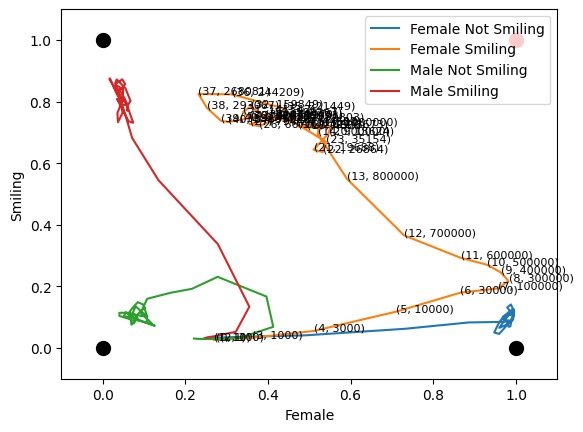

In [101]:
smooth_traj=sim.gaussian_filter1d(traj,sigma=0.9,axis=1)
#smooth_traj=traj
for i in range(4):
    plt.plot(smooth_traj[i,:,0],smooth_traj[i,:,1],label=labels[i])
    if i==i_testing:
        for j in range(len(ckpt_paths)):
            plt.text(smooth_traj[i,j,0],smooth_traj[i,j,1],str((j,steps[j])),fontsize=8)
plt.legend()
plt.scatter([0,0,1],[0,1,0],c="black",s=100)
plt.scatter([1],[1],c="red",s=100)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel(ax_names[0])
plt.ylabel(ax_names[1])